**Brian Blaylock**  
**January 16, 2019**


# GLM: Remove False Flashes on the _Bahama Bar_

The "Bahama Bar" is a area the GLM instrument tends to record false flashes when the clouds are bright. It is caused by sun glint along the sensors CCD subarrays. It appears the location of these artifacts lies near `25.7 N` and  `-21.7 S`. There is a fix for this in the future, but for archived GLM flashes, I need to remove them myself.

Artifacts in the GLM Level 2 data are highlighted in a recent paper, [Rudlosky et al. 2018](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018GL081052), and also obvious in my [Summer 2018 Lightning Climatology](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/glm_accumulation_viewer.cgi).

<img src='http://home.chpc.utah.edu/~u0553130/PhD/GOES16_GLM/Hourly_May2018-Oct2018/GLM/animated.gif' width=350px>

According to the [Provisional Maturity document](https://www.ncdc.noaa.gov/sites/default/files/attachments/ReadMe_GLM-LCFA_Provisional_Maturity.pdf)
relased on 18 January 2018, there are plans to reduce solar glint effects on false flashes. 
>False events due to blooming, created from glint and/or solar intrusion, are still present but a blooming filter and improvements to glint processing are planned

---
Is there a way to remove these false flashes this myself?

Example ABI Image: [click here](https://pando-rgw01.chpc.utah.edu/GOES16/ABI-L2-MCMIPC/20180911/OR_ABI-L2-MCMIPC-M3_G16_s20182541717131_e20182541719503_c20182541720018.png) 

<img width=50% src='https://pando-rgw01.chpc.utah.edu/GOES16/ABI-L2-MCMIPC/20180911/OR_ABI-L2-MCMIPC-M3_G16_s20182541717131_e20182541719503_c20182541720018.png'>

ABI File Name: `OR_ABI-L2-MCMIPC-M3_G16_s20182541717131_e20182541719503_c20182541720018.nc`

From an email from Eric Bruning:
>There is not yet an algorithm for filtering those points on archived data. A fix is in the works for the future, though on your retrospective data you’ll have to roll your own solution.  
The artifact you’ve pointed out in this case is along a GLM CCD subarray boundary, and is affectionately known as the “Bahama Bar.” It is indeed due to bright cloud tops, and is produced by a bit of a different mechanism than the artifacts that sometimes happen due to glint from the ocean surface (which can happen anywhere, even away from the subarray boundary).   
The position of that artifact shouldn’t change too much, so in principle it’d be easy to mask out/ignore that area as part of validation, with the downside of loss of any real lightning signal that might be embedded within the artifact. It might be possible to look at statistics of the data (energy, flash area, flash aspect ratio, number of groups and events per flash, etc.) to quantify a confidence the event is real. I'd probably start there if I wanted to automate the identification of artifacts. If you come up with a good solution, I and many others would love to hear about it!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, pluck_hrrr_point
from BB_GOES.get_GLM import get_GLM_files_for_range, accumulate_GLM_FAST, get_GLM_files_for_ABI, accumulate_GLM
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap, draw_GLM_map, draw_GOES_East_geo
from mpl_toolkits.basemap import Basemap

In [2]:
m = draw_GLM_map()

In [3]:
mH = draw_HRRR_map()

In [4]:
mG = draw_GOES_East_geo()

In [8]:
filesABI = get_GLM_files_for_ABI(FILE='OR_ABI-L2-MCMIPC-M3_G16_s20182541717131_e20182541719503_c20182541720018.nc')

In [9]:
filesABI

{'Files': ['/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541717000_e20182541717200_c20182541717217.nc',
  '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541717200_e20182541717400_c20182541717430.nc',
  '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541717400_e20182541718000_c20182541718028.nc',
  '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541718000_e20182541718200_c20182541718227.nc',
  '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541718200_e20182541718400_c20182541718420.nc',
  '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541718400_e20182541719000_c20182541719026.nc',
  '/uufs/chpc.utah.edu/common/home/horel-gr

In [10]:
filesABI['Files'][0]

'/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA//20180911/17/OR_GLM-L2-LCFA_G16_s20182541717000_e20182541717200_c20182541717217.nc'

In [12]:
# Open a single file
d = xarray.open_dataset(filesABI['Files'][5])

In [13]:
# Open all the files for the ABI scan
dd = {}
for i, file in enumerate(filesABI['Files']):
    dd[i] = xarray.open_dataset(file)

In [14]:
# Concatenate all the files for variables I want along the dimension "number_of_flashes"
flash_lon = xarray.concat([dd[i].flash_lon for i in dd.keys()], dim='number_of_flashes')
flash_lat = xarray.concat([dd[i].flash_lat for i in dd.keys()], dim='number_of_flashes')
flash_area = xarray.concat([dd[i].flash_area for i in dd.keys()], dim='number_of_flashes')
flash_id = xarray.concat([dd[i].flash_id for i in dd.keys()], dim='number_of_flashes')
flash_energy = xarray.concat([dd[i].flash_energy for i in dd.keys()], dim='number_of_flashes')
flash_quality_flag = xarray.concat([dd[i].flash_quality_flag for i in dd.keys()], dim='number_of_flashes')

flash_time_offset_of_first_event = xarray.concat([dd[i].flash_time_offset_of_first_event for i in dd.keys()], dim='number_of_flashes')
flash_time_offset_of_last_event = xarray.concat([dd[i].flash_time_offset_of_last_event for i in dd.keys()], dim='number_of_flashes')

group_parent_flash_id = xarray.concat([dd[i].group_parent_flash_id for i in dd.keys()], dim='number_of_groups')

# Can we filter flashes based on a long or short flash?

The _Bahamas Bar_ is generally associated with shorter flashes, less than 0.02 s in duration, but not conclusive.

Text(0,0.5,'count')

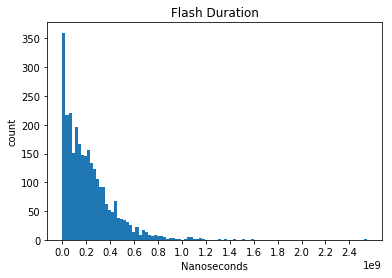

In [15]:
dt = (flash_time_offset_of_last_event-flash_time_offset_of_first_event).data
plt.hist([float(i) for i in dt], bins=100);
plt.xticks(np.arange(0,2.5e9,.2e9));
plt.title('Flash Duration')
plt.xlabel('Nanoseconds')
plt.ylabel('count')

In [17]:
print(np.max(dt))
print(np.min(dt))

2546000000 nanoseconds
0 nanoseconds


num long flashes 245
num short flashes 396


Text(0.5,1,'Flash Duration')

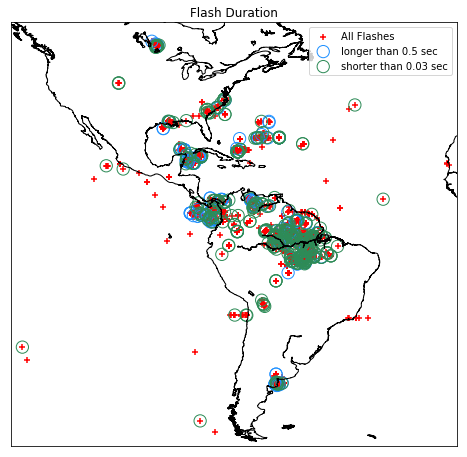

In [29]:
threshold = int(.5e9)
threshold2 = int(.03e9)
logic = dt > np.timedelta64(threshold)
logic2 = dt < np.timedelta64(threshold2)
print('num long flashes', sum(logic))
print('num short flashes', sum(logic2))

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
           latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[logic], flash_lat[logic],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', label='longer than %s sec' % (float(threshold)/1e9))
m.scatter(flash_lon[logic2], flash_lat[logic2],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='seagreen', label='shorter than %s sec' % (float(threshold2)/1e9))
m.drawcoastlines()

plt.legend()
plt.title('Flash Duration')

# Is false flashes dependent on flash size?
The _Bahamas Bar_ flashes are typically small flashes, less than 100 km2

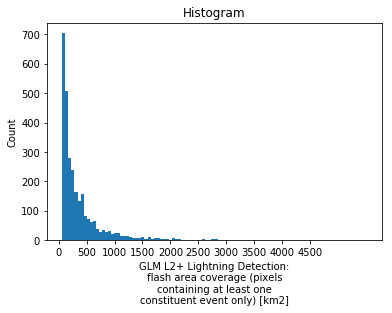

In [19]:
flash_area.plot.hist(bins=100);
plt.gca()
plt.xticks(range(0,5000,500));

num small flash 655
num large flash 356


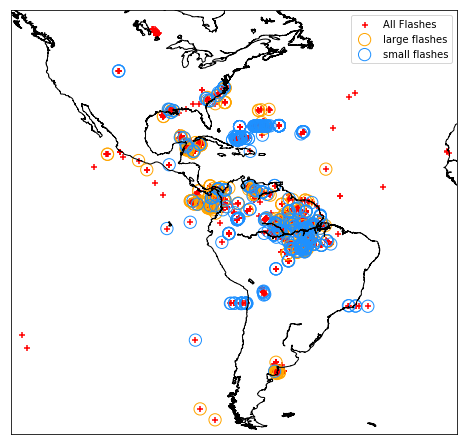

In [20]:
logic = flash_area < 80
logic2 = flash_area > 700
print('num small flash', sum(logic.data))
print('num large flash', sum(logic2.data))

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
           latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[logic2], flash_lat[logic2],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='orange', label='large flashes')
m.scatter(flash_lon[logic], flash_lat[logic],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', label='small flashes')
m.drawcoastlines()

plt.legend()

# What if we filter flashes with only two groups?
Most flashes in the Bahama Bar have few groups, but some have many groups

In [21]:
# Count number of unique groups
unique, counts = np.unique(group_parent_flash_id, return_counts=True)

Text(0.5,0,'groups per flash')

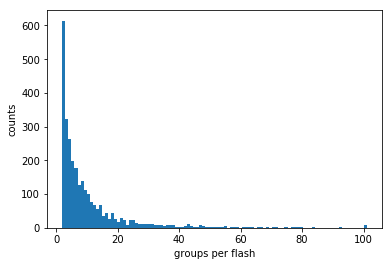

In [22]:
plt.hist(counts, 100);
plt.ylabel('counts')
plt.xlabel('groups per flash')

In [23]:
few_groups = unique[counts<5]
many_groups = unique[counts>40]

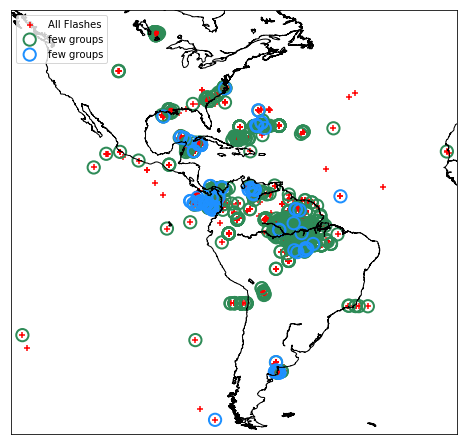

In [24]:
few_group_logic = np.array([i in few_groups for i in flash_id.data])
many_group_logic = np.array([i in many_groups for i in flash_id.data])

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
          latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[few_group_logic], flash_lat[few_group_logic],
          latlon=True, marker='o', s=150, facecolor='none', edgecolor='seagreen', linewidth=2, label='few groups')
m.scatter(flash_lon[many_group_logic], flash_lat[many_group_logic],
          latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', linewidth=2, label='few groups')
m.drawcoastlines()

plt.legend(loc=2)

# Filter by flash energy?

Bahamas bar has low energy flashes

(0, 2e-12)

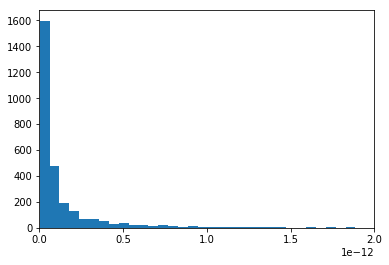

In [25]:
plt.hist(flash_energy, bins=100);
plt.xticks(np.arange(0,6e-12,.5e-12));
plt.xlim(0, 2e-12)

num high energy flashes 78
num low energy flashes 351


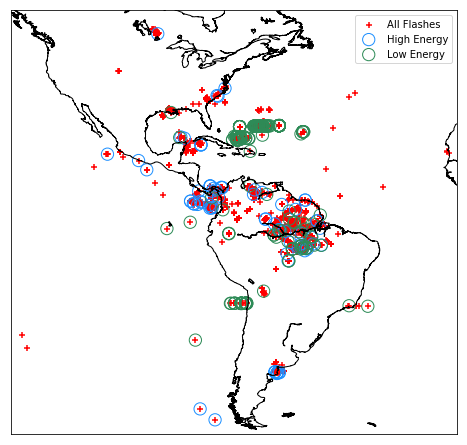

In [26]:
threshold = 1e-12
threshold2 = .006e-12
logic = flash_energy > threshold
logic2 = flash_energy < threshold2
print('num high energy flashes', sum(logic.data))
print('num low energy flashes', sum(logic2.data))

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
           latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[logic], flash_lat[logic],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', label='High Energy')
m.scatter(flash_lon[logic2], flash_lat[logic2],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='seagreen', label='Low Energy')
m.drawcoastlines()

plt.legend()

# Filter by Latitude:
Bahamas Bar lies near `25.7 N` and `21.7 S`

num long flashes 179
num short flashes 35


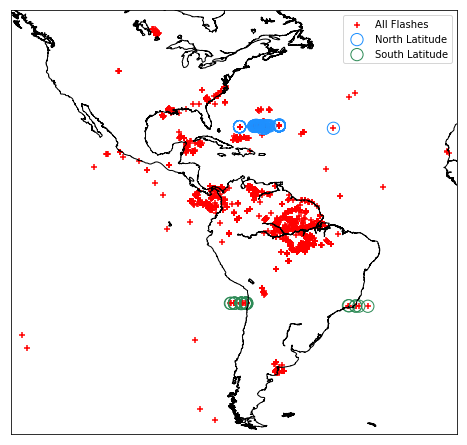

In [27]:
north = 25.7
south = -21.7
logic = np.logical_and(flash_lat > north-1, flash_lat < north+1)
logic2 = np.logical_and(flash_lat > south-1, flash_lat < south+1)
print('num long flashes', sum(logic.data))
print('num short flashes', sum(logic2.data))

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
           latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[logic], flash_lat[logic],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', label='North Latitude')
m.scatter(flash_lon[logic2], flash_lat[logic2],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='seagreen', label='South Latitude')
m.drawcoastlines()

plt.legend()

# Filter poor flash quality
Nope, there are no bad quality flahses in the _Bahama Bar_

num low quality flashes: 8
bad data flag value: [3. 3. 3. 3. 3. 3. 3. 3.]


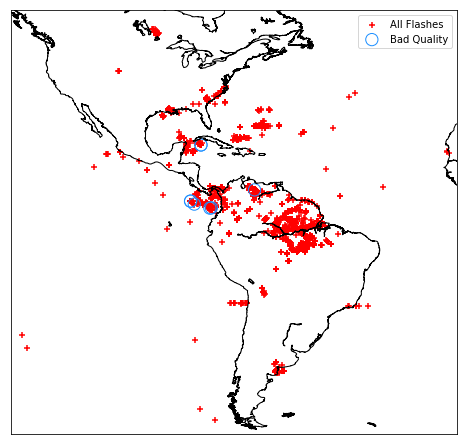

In [30]:
bad_quality = np.where(flash_quality_flag>0)
print('num low quality flashes:', len(bad_quality[0]))
print('bad data flag value:', flash_quality_flag.data[bad_quality])

plt.figure(figsize=(8,8))
m.scatter(flash_lon, flash_lat,
           latlon=True, marker='+', color='r', label='All Flashes')
m.scatter(flash_lon[bad_quality], flash_lat[bad_quality],
           latlon=True, marker='o', s=150, facecolor='none', edgecolor='dodgerblue', label='Bad Quality')
m.drawcoastlines()

plt.legend()